In [1]:
from typing import List
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

random_state = 10
rng = np.random.RandomState(random_state)

Возьмем следующий датасет, он доступен по  ссылке:
https://ourworldindata.org/coronavirus-source-data

Зафиксируем тренировочный набор в виде первых 50 дней, начиная с 3 марта (в этот момент впервые стало больше 2 заболевших).

In [2]:
data = pd.read_csv('owid-covid-data.csv', parse_dates=['date'])

data_ru = data[(data['location'] == 'Russia') & (data['date'] >= '2020-03-03')].reset_index(drop=True)


def train_test_split(data: pd.DataFrame, num_row: int = 50):
    data['new_cases'] = data['new_cases'].fillna(1)
    data.loc[data["new_cases"] == 0, "new_cases"] = 1
    data.sort_values('date', ascending=True, inplace=True)

    data_train = data.iloc[:num_row].reset_index()
    data_test = data.iloc[num_row:].reset_index()

    data_train.rename({'index':'day'}, inplace=True, axis=1)
    data_test.rename({'index':'day'}, inplace=True, axis=1)

    data_train['day'] += 1
    data_test['day'] += 1

    X_train, y_train = data_train[['day']], data_train[['total_cases', 'new_cases']]
    X_test, y_test = data_test[['day']], data_test[['total_cases', 'new_cases']]

    return X_train, y_train, X_test, y_test

In [3]:
X_train, y_train, X_test, y_test = train_test_split(data_ru)

Отобразим динамику количества заболевших, заметно, что в начале пандемии число новых случаев и общее число заболеваний растёт очень быстро.

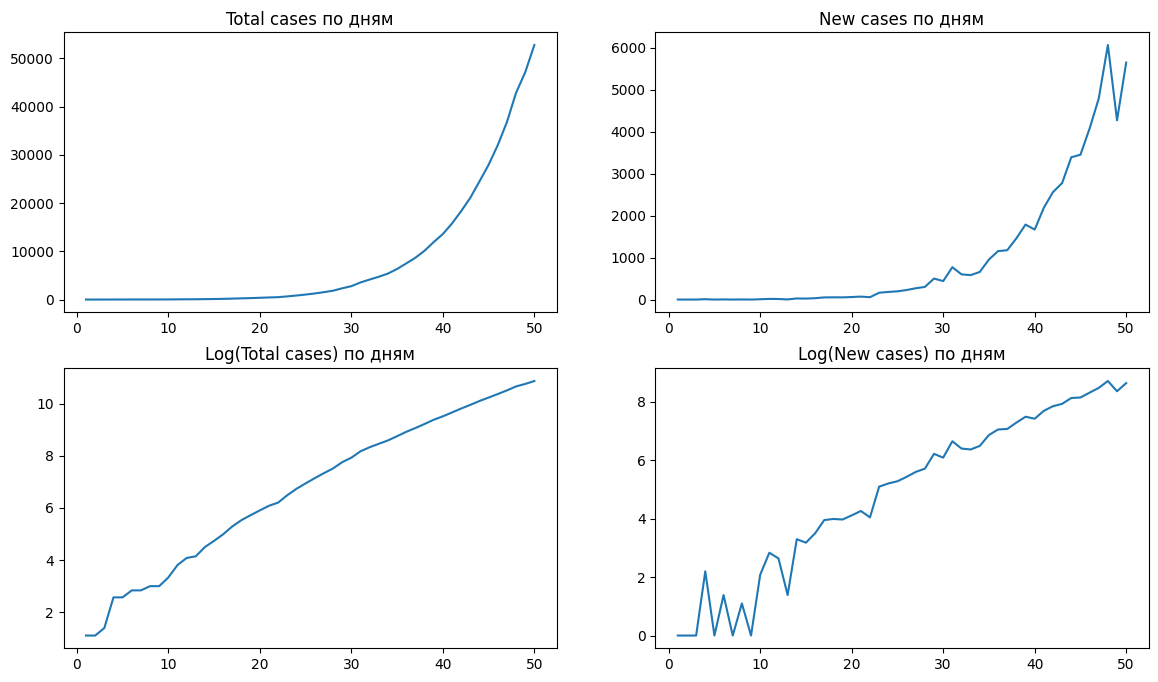

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax[0, 0].plot(X_train.day, y_train.total_cases)
ax[0, 1].plot(X_train.day, y_train.new_cases)
ax[1, 0].plot(X_train.day, np.log(y_train.total_cases))
ax[1, 1].plot(X_train.day, np.log(y_train.new_cases))

ax[0, 0].set_title("Total cases по дням")
ax[0, 1].set_title("New cases по дням")
ax[1, 0].set_title("Log(Total cases) по дням")
ax[1, 1].set_title("Log(New cases) по дням")
plt.show()

Используя линейную регрессию, обучим модели с экспоненциальным
ростом числа заболевших y ~ exp(линейная функция от x), где x — номер текущего дня, в качестве целевых переменных будем использовать прологарифмированные значения Total cases и New cases.

In [5]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [6]:
lr_total_cases = LinearRegression()
lr_new_cases = LinearRegression()

lr_total_cases.fit(X_train['day'].values.reshape(-1, 1), y_train_log['total_cases'])
lr_new_cases.fit(X_train['day'].values.reshape(-1, 1), y_train_log['new_cases'])

print(f"Модель для Total cases: y ~ exp({lr_total_cases.intercept_} + {lr_total_cases.coef_[0]}*x)")
print(f"Модель для New cases: y ~ exp({lr_new_cases.intercept_} + {lr_new_cases.coef_[0]}*x)")

Модель для Total cases: y ~ exp(1.6224462364488117 + 0.19829091233588558*x)
Модель для New cases: y ~ exp(0.13472442721454225 + 0.1859630916851052*x)


In [7]:
def plot_predict(X_train, X_test, y_train, y_test, predict_train, predict_test):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(X_train.day, y_train, label='Реальные данные', color="xkcd:coral")
    ax[0].plot(X_train.day, predict_train, label='Предсказания', color="xkcd:tangerine")
    ax[1].plot(X_test.day, y_test, label='Реальные данные', color="xkcd:coral")
    ax[1].plot(X_test.day, predict_test, label='Предсказания', color="xkcd:tangerine")

    ax[0].set_title("Total cases по дням (тренировочные данные)")
    ax[1].set_title("Total cases по дням (тестовые данные)")
    ax[0].legend()
    ax[1].legend()
    plt.show()

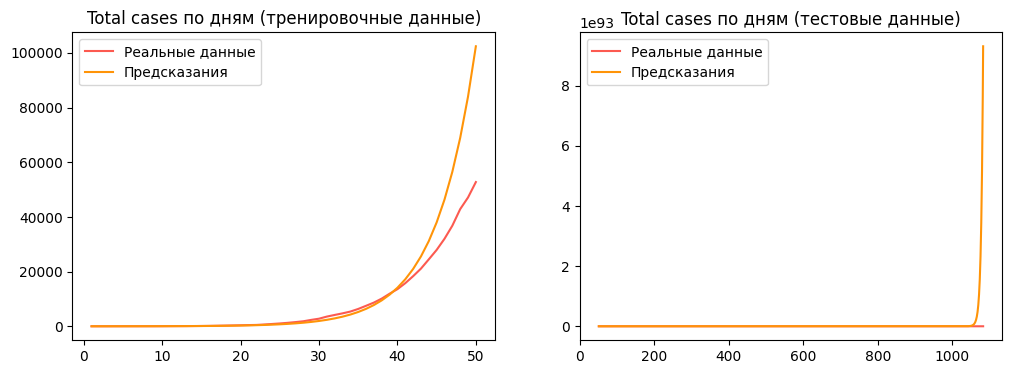

In [8]:
plot_predict(
    X_train,
    X_test,
    y_train.total_cases,
    y_test.total_cases,
    np.exp(lr_total_cases.predict(X_train.day.values.reshape(-1, 1))),
    np.exp(lr_total_cases.predict(X_test.day.values.reshape(-1, 1))),
)

Отобразим априорное распределение параметров модели, будем использовать модель для Total cases. В качестве априорного выберем нормальное с нулевым средним и диагональной ковариационной матрицей.

In [9]:
class Distribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov

    def __str__(self):
        return f"GaussianDistribution: \nmean={self.mean} \ncov=\n{self.cov}"

In [10]:
prior_distribution = Distribution(mean=np.zeros(2), cov=np.eye(2))
sigma_noise = np.std(lr_total_cases.predict(X_train.day.values.reshape(-1, 1)) - y_train_log.total_cases)

In [11]:
def plot_heatmap(x_linspace, y_linspace, mu, sigma):
    N = 250
    X = np.linspace(x_linspace[0], x_linspace[1], N)
    Y = np.linspace(y_linspace[0], y_linspace[1], N)
    X, Y = np.meshgrid(X, Y)

    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    Z = multivariate_normal.pdf(pos, mean=mu, cov=sigma)

    fig = plt.figure(figsize=(12, 6))
    plt.axis('equal')
    plt.xlim((x_linspace[0], x_linspace[1]))
    plt.ylim((y_linspace[0], y_linspace[1]))
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)

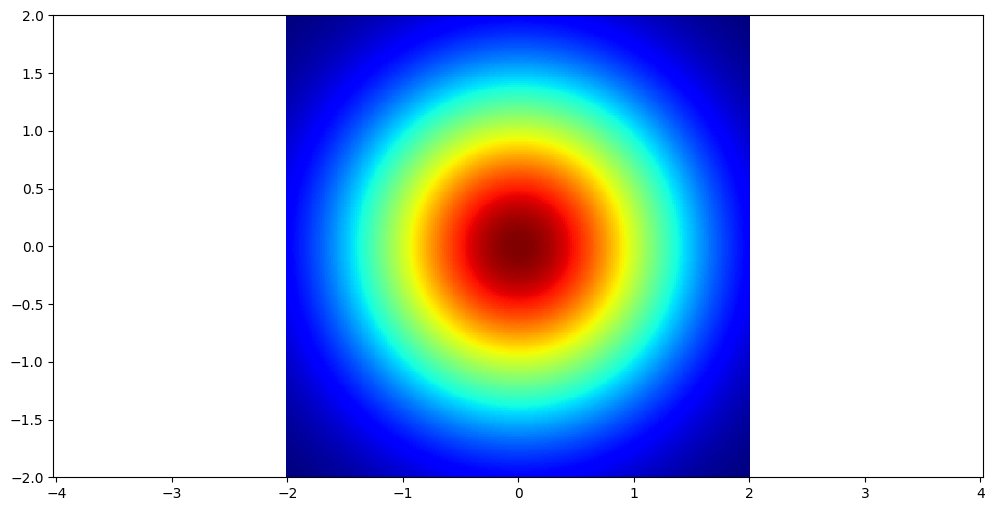

In [12]:
plot_heatmap(
    x_linspace=(-2, 2), 
    y_linspace=(-2, 2), 
    mu=prior_distribution.mean, 
    sigma=prior_distribution.cov,
    )

Теперь найдем апостериорное распределение параметров модели ${\Phi = (\phi_{j}(x_{i}))_{i,j}}$. 
$$
{p(\mathrm{w} \mid t) = \mathcal{N} (\mathrm{w} \mid \mu_{N}, \Sigma_{N})}
\text{,}$$

$$
{\mu_{n} = \Sigma_{N} (\Sigma_{0}^{-1} \mu_{0} + {1 \over \sigma^{2}} \mathrm \Phi^{\mathrm {T}} \mathrm {t})}$$

$$
{\Sigma_{n} = (\Sigma_{0}^{-1} + {1 \over \sigma^{2}} \mathrm \Phi^{\mathrm {T}} \mathrm {\Phi})^{-1}}
$$

In [13]:
X = np.hstack((
    np.ones(X_train.shape[0]).reshape(-1, 1),
    X_train.day.values.reshape(-1, 1)
))

sigma_N = np.linalg.inv(prior_distribution.cov + X.T @ X / (sigma_noise ** 2))
mu_N = sigma_N @ (prior_distribution.cov @ prior_distribution.mean + X.T @ y_train_log.total_cases / (sigma_noise ** 2))

posterior_distribution = Distribution(mean=mu_N, cov=sigma_N)
print(posterior_distribution)

GaussianDistribution: 
mean=[1.60636988 0.19876786] 
cov=
[[ 9.94481545e-03 -2.95389720e-04]
 [-2.95389720e-04  1.16121360e-05]]


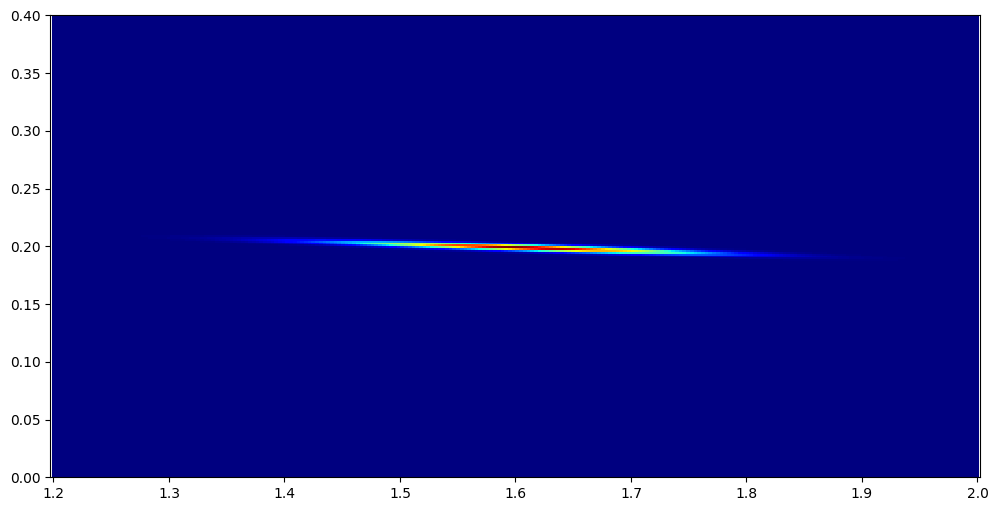

In [14]:
plot_heatmap(
    x_linspace=(1.2, 2), 
    y_linspace=(0, 0.4), 
    mu=posterior_distribution.mean, 
    sigma=posterior_distribution.cov,
    )

Посэмплируем 1000 разных экспонент и построим некоторые из них. Также отобразим предсказательные распределения для первого числа месяцев (май, июнь, сентябрь), исходя из данных сэмплирования.

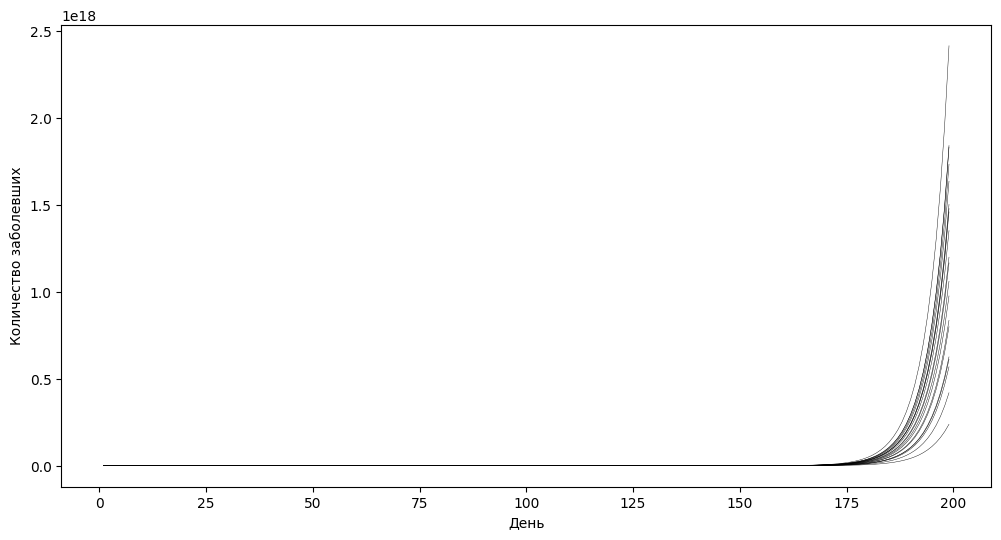

In [15]:
may, june, september = [], [], []
days = np.arange(1, 200, 1)
weights = rng.multivariate_normal(posterior_distribution.mean, posterior_distribution.cov, 1000)

fig = plt.figure(figsize=(12, 6))
for idx, w in enumerate(weights):
    may.append(np.exp(w[0] + w[1] * 60))
    june.append(np.exp(w[0] + w[1] * 91))
    september.append(np.exp(w[0] + w[1] * 183))
    
    if idx % 50 == 0:
        plt.plot(days, np.exp(w[0] + w[1] * days), 'k-', lw=.3)
        plt.xlabel('День')
        plt.ylabel('Количество заболевших')

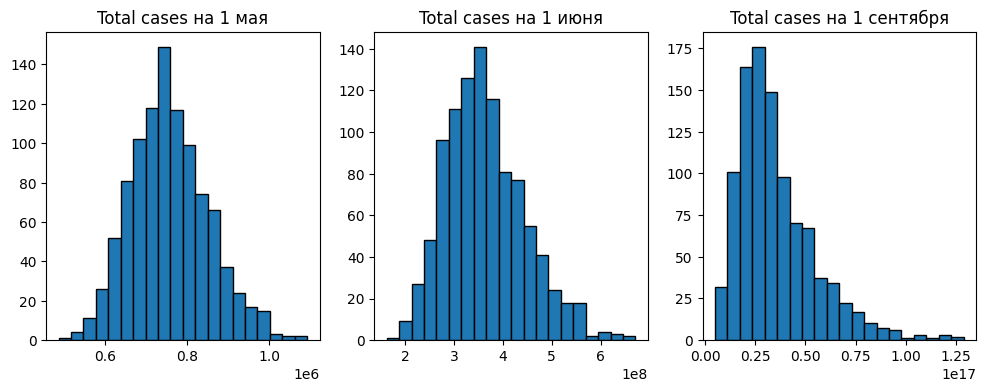

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(may, edgecolor='black', bins=20)
ax[1].hist(june, edgecolor='black', bins=20)
ax[2].hist(september, edgecolor='black', bins=20)

ax[0].set_title("Total cases на 1 мая")
ax[1].set_title("Total cases на 1 июня")
ax[2].set_title("Total cases на 1 сентября")
plt.show()

In [17]:
result = data_ru[data_ru['date'].isin(['2020-05-01', '2020-06-01', '2020-09-01'])][['date', 'total_cases']]
result['predict_exp'] = [int(np.mean(may)), int(np.mean(june)), int(np.mean(september))]
result

,date,total_cases,predict_exp
59,2020-05-01,114431.0,757513
90,2020-06-01,414328.0,364650624
182,2020-09-01,997072.0,35401810809311168


Очевидно, что экспоненциальная модель не лучший вариант для решения данной задачи, исходя из ее результатов к 1 сентября заболевших в России будет больше, чем людей на Земле.

Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды возьмём форму функции распределения для гауссиана:
$$
{\displaystyle \Phi(x)={\frac {1}{\sqrt {2\pi}}}\int _{-\infty}^{x}e^{-t^{2}/2}\ dt}
$$

В нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной, а в экспоненте под интегралом может быть произвольная квадратичная функция от t. Тогда мы можем продифференцировать сигмоиду под знаком интеграла. Полученный результат прологарифмируем по основанию $e$.

$$
\ln({d \Phi(x) \over dt}) = w_{0} + w_{1}t + w_{2}t^{2}, w_0 = (1, \dots, 1 )^{\mathrm T}
$$

$${
{d \Phi(x) \over dt} = NewCases
}$$

Тогда получим:

$${
\ln({\mathrm {NewCases}}) = w_{0} + w_{1}t + w_{2}t^{2}
}$$

$${
{\mathrm {TotalCases}} = \mathrm{cumsum(\mathrm{exp}(w_{0} + w_{1}t + w_{2}t^{2}))}
}$$

In [18]:
lr_sigmoid = LinearRegression(fit_intercept=False)
lr_sigmoid.fit(
    np.hstack((
    np.ones(X_train.shape[0]).reshape(-1, 1),
    X_train['day'].values.reshape(-1, 1),
    X_train['day'].values.reshape(-1, 1) ** 2,
    )), 
    y_train_log.new_cases
    );

f = lambda x : lr_sigmoid.coef_[0] + lr_sigmoid.coef_[1] * x + lr_sigmoid.coef_[2] * (x ** 2)

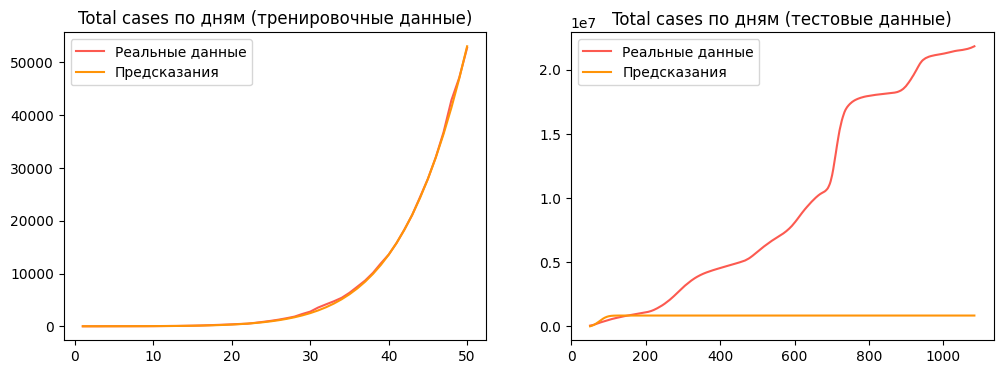

In [19]:
plot_predict(
    X_train,
    X_test,
    y_train.total_cases,
    y_test.total_cases,
    np.cumsum(np.round(np.exp(f(X_train.day.values.reshape(-1, 1))))),
    np.cumsum(np.round(np.exp(f(X_test.day.values.reshape(-1, 1)))))
)


Качество на тренировочных данных хорошее, но поскольку мы брали только первых 50 дней для обучения, модель не может точно аппроксимировать функцию на всей области.

Найдем апостериорное распределение параметров модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оценим, исходя из максимальной апостериорной модели.

In [20]:
sigma_noise = np.std(f(X_train.day.values) - y_train_log.new_cases)
prior_distribution = Distribution(mean=np.zeros(3), cov=np.eye(3))

In [21]:
X = np.hstack((
    np.ones(X_train.shape[0]).reshape(-1, 1),
    X_train.day.values.reshape(-1, 1),
    X_train.day.values.reshape(-1, 1) ** 2,
    ))


sigma_N = np.linalg.inv(prior_distribution.cov + X.T @ X / (sigma_noise ** 2))
mu_N = sigma_N @ (prior_distribution.cov @ prior_distribution.mean + X.T @ y_train_log.new_cases / (sigma_noise ** 2))

posterior_distribution = Distribution(mean=mu_N, cov=sigma_N)
print(posterior_distribution)

GaussianDistribution: 
mean=[-0.6429853   0.27679809 -0.00178859] 
cov=
[[ 4.46128406e-02 -3.53279772e-03  5.82943886e-05]
 [-3.53279772e-03  3.68983203e-04 -6.82512164e-06]
 [ 5.82943886e-05 -6.82512164e-06  1.34498814e-07]]


Посэмплируем 1000 разных сигмоид и построим некоторые из них. Узнаем сколько, исходя из этих сэмплов, будет всего случаев коронавируса в России и отобразим эмпирическое предсказательное распределение

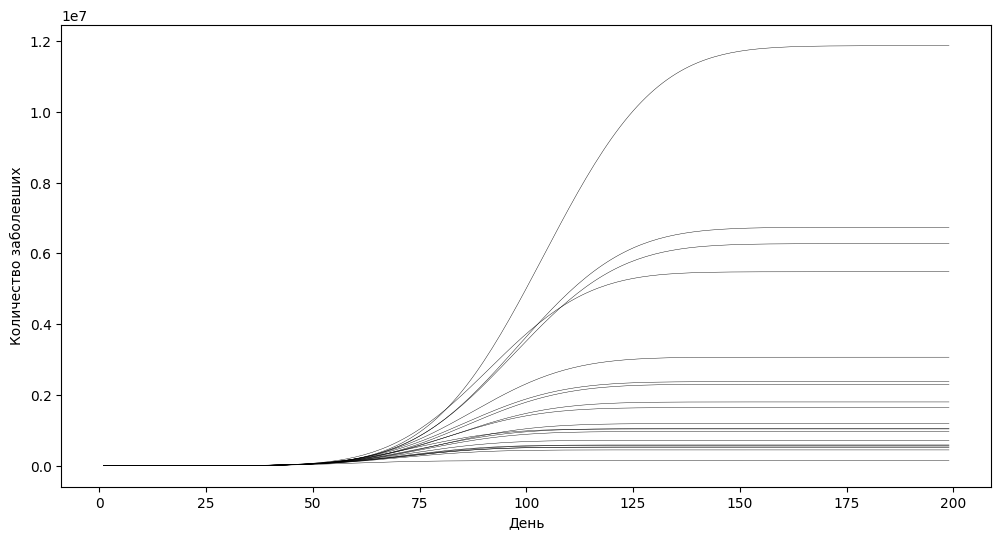

In [22]:
result_total_cases = []
days = np.arange(1, 200, 1)
weights = rng.multivariate_normal(posterior_distribution.mean, posterior_distribution.cov, 1000)

fig = plt.figure(figsize=(12, 6))
for idx, w in enumerate(weights):
    result_total_cases.append(np.cumsum(np.round(np.exp(w[0] + w[1] * days + w[2] * days * days)))[-1])
    
    if idx % 50 == 0:
        plt.plot(days, np.cumsum(np.round(np.exp(w[0] + w[1] * days + w[2] * days * days))), 'k-', lw=.3)
        plt.xlabel('День')
        plt.ylabel('Количество заболевших')

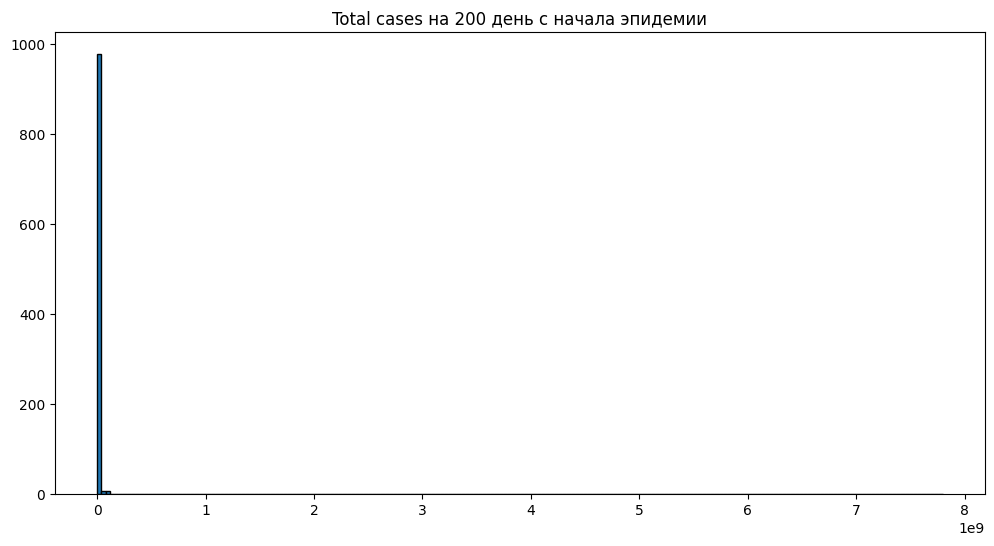

In [23]:
fig = plt.figure(figsize=(12, 6))
plt.hist(result_total_cases, edgecolor='black', bins=200)
plt.title("Total cases на 200 день с начала эпидемии")
plt.show()

In [24]:
print(f"Прогноз числа случаев коронавируса в России в среднем: {int(np.median(result_total_cases))}")
print(f"В пессимистичном сценарии (90-й процентиль в выборке числа случаев): {int(np.percentile(result_total_cases, 90))}")
print(f"В оптимистичном сценарии (10-й процентиль в выборке числа случаев): {int(np.percentile(result_total_cases, 10))}")

Прогноз числа случаев коронавируса в России в среднем: 988414
В пессимистичном сценарии (90-й процентиль в выборке числа случаев): 6692698
В оптимистичном сценарии (10-й процентиль в выборке числа случаев): 321178


Посмотрим как меняется ситуация для разных стран и узнаем, что происходит с параметрами модели. Для каждой страны будет определена своя дата начала пандемии, моментом отсчета будем считать день, когда дневной абсолютный прирост общего числа заболевших стал больше 4 человек. Также для обучающей выборки будем брать первые 200 дней с начала пандемии, чтобы поточнее обучить параметры модели.

In [25]:
location_info = []
for location in data.location.unique():
    
    data_location = data[data['location'] == location]
    data_location.sort_values('date', ascending=True, inplace=True)
    data_location['diff'] = data_location['total_cases'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
    data_location = data_location[data_location['diff'] > 4]

    if data_location.shape[0] != 0:
        start_date = data_location['date'].iloc[0]
        location_info.append([location, start_date])

location_info = pd.DataFrame(location_info, columns=['location', 'start_date'])

In [26]:
location_info['w0'], location_info['w1'], location_info['w2'] = None, None, None

for idx, row in location_info.iterrows(): 
    data_location = data[(data['location'] == row['location']) & (data['date'] >= row['start_date'])].reset_index(drop=True)
    num_row = 200
    if data_location.shape[0] > num_row * 2:
        X_train, y_train, X_test, y_test = train_test_split(data_location, num_row)
        y_train_log = np.log(y_train)
        y_test_log = np.log(y_test)

        lr_location = LinearRegression(fit_intercept=False)
        lr_location.fit(
            np.hstack((
            np.ones(X_train.shape[0]).reshape(-1, 1),
            X_train['day'].values.reshape(-1, 1),
            X_train['day'].values.reshape(-1, 1) ** 2,
            )), 
            y_train_log.new_cases
            );
        
        f = lambda x : lr_location.coef_[0] + lr_location.coef_[1] * x + lr_location.coef_[2] * (x ** 2)
        location_info.at[idx, 'w0'] = lr_location.coef_[0]
        location_info.at[idx, 'w1'] = lr_location.coef_[1]
        location_info.at[idx, 'w2'] = lr_location.coef_[2]

In [27]:
countries = [
    'Albania', 'Andorra', 'Argentina', 'Armenia', 'Austria', 'Azerbaijan', 
    'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia', 'Brazil', 
    'Brunei', 'Bulgaria', 'Burundi', 'Canada', 'Chad', 'Chile', 
    'China', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Ecuador', 
    'Egypt', 'Estonia', 'Ethiopia','France', 'Gabon', 'Gambia', 'Georgia', 
    'Greece', 'Guatemala', 'Guinea', 'Honduras', 'India', 'Indonesia', 
    'Iran', 'Iraq', 'Israel', 'Italy', 'Jamaica', 'Japan', 
    'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Lithuania', 'Latvia', 'Luxembourg',
    'Madagascar', 'Malta', 'Mauritania', 'Mexico', 'Moldova', 'Monaco',
    'Montenegro', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand', 'Nicaragua', 
    'Niger', 'Norway', 'Pakistan', 'Palestine', 'Panama', 'Paraguay', 'Peru',
    'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Rwanda', 
    'Senegal', 'Serbia', 'Slovakia', 'Slovenia', 'South Korea', 'Spain', 
    'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Tanzania', 'Tunisia', 
    'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Vietnam', 'Zambia'
    ]

In [28]:
visual_data = location_info[(location_info['location'].isin(countries))]
fig = px.scatter_3d(visual_data, x="w0", y="w1", z="w2", text="location", opacity=0.4, height=1000)
fig.update_traces(marker_size=3)
fig.show()

Картинка статичная, можно увидеть интерактивный вариант, запустив код выше 

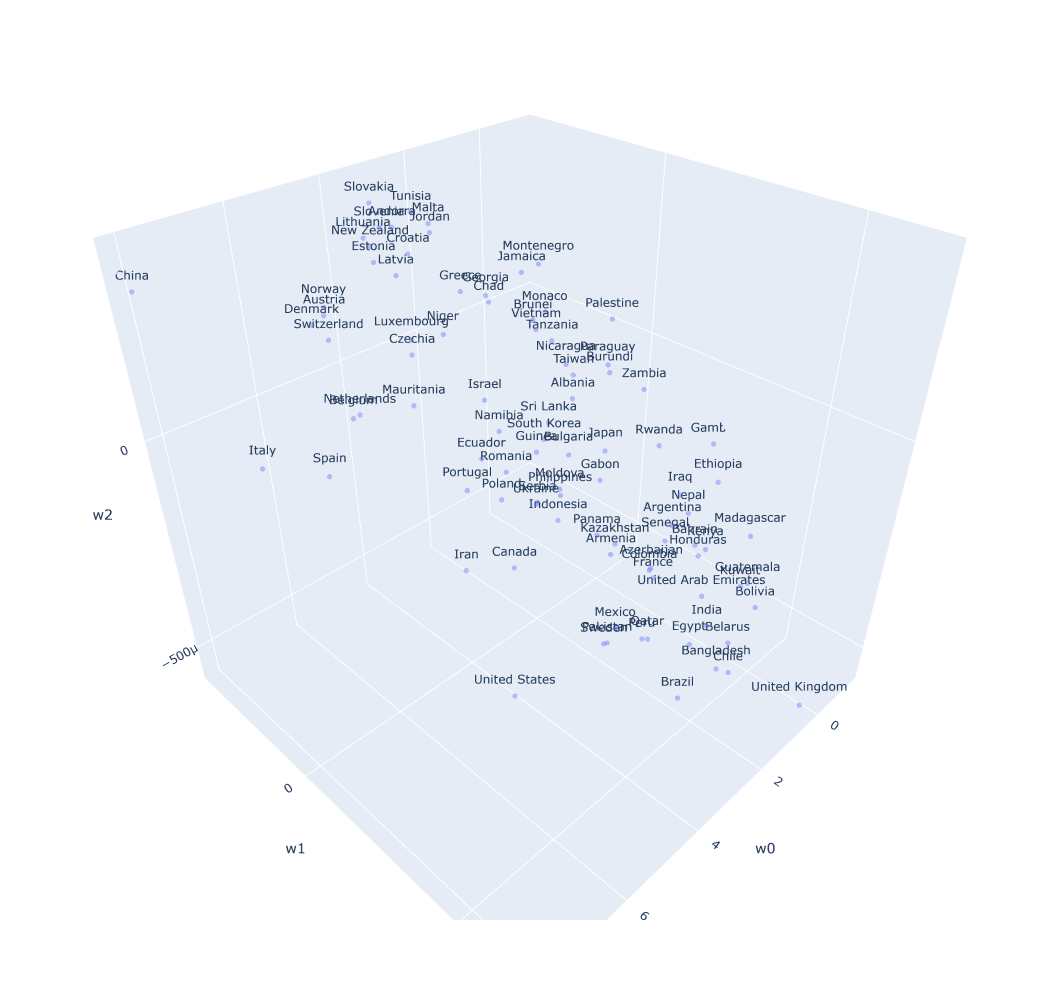

**Основные выводы:**  
-  Отобразив для разных стран полученные параметры моделей, можно заметить, что Китай, Италия, Испания и США находятся вне общего облака точек, как раз для этих стран было характерно наиболее стремительное развитие и распространение коронавируса. Заметны отдельно находящиеся скопления точек: стран Балтии (Латвия, Литва, Эстония), "богатых" европейских стран (Норвегия, Швейцария, Дания, Австрия). Также лично для меня было интересно узнать, где в этой системе координат находится Беларусь, оказалось, в противоположной стороне от ранее названных стран, что можно связать с проведением отличающихся санитарно-эпидемиологических мероприятий, например, локдаун не вводился;

- Кривая общего числа заболевших в период пандемии в реальности имеет сигмоидальный вид;

- Коронавирус распростронялся очень быстро как по всему миру, так и в рамках каждой из стран. Стоит отметить, что результаты моделирования будут меняться в зависимости от длины рассматриваемого временного ряда, поэтому лицо принимающее решение может ежедневно увеличивать объем тренировочных данных, тем самым уточняя параметры модели;

- Используемая методология хороша своей простотой, но для принятия решения о введении карантина стоит учитывать и другие факторы. 